# 测试不同的判别方法

In [ ]:
!pip install scikit-learn

In [104]:
import torch
from torch.utils.data import DataLoader
import clip
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
from torchvision.datasets import ImageFolder
from typing import List, Tuple, Dict, Union, Optional, Callable, Any, cast
from pathlib import Path
import os

## 验证英文CLIP模型的效果

In [105]:
# 加载CLIP模型和对应的预处理方法
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

加载数据集

In [155]:
def zeroshot_classifier(test_loader, text_inputs, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # 计算图像特征
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            # 计算文本特征
            text_features = model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            # 计算相似度（例如：进行零样本分类）
            similarity = (image_features @ text_features.T).softmax(dim=-1)
            
            predicted_indices = similarity.argmax(dim=-1)
            # 可将predicted_indices与labels对比，计算准确率等
            all_preds.extend(predicted_indices.cpu().numpy())
            all_labels.extend(labels.numpy())  # labels 已经是二元标签
    return all_preds, all_labels

重写Dataset类，灵活处理label的问题。

In [107]:
"""参考DatasetFolder类源码：
https://pytorch.org/vision/stable/generated/torchvision.datasets.DatasetFolder.html#torchvision.datasets.DatasetFolder"""
from torchvision.datasets import VisionDataset
from PIL import Image

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")
background_color=(255, 255, 255)

def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    if has_transparency(path):
        with Image.open(path).convert('RGBA') as img:
            background = Image.new('RGB', img.size, background_color)
            background.paste(img, mask=img.split()[-1])  # 使用Alpha通道作为蒙版
            return background
    else:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

def default_loader(path: str) -> Any:
    from torchvision import get_image_backend

    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)

def has_file_allowed_extension(filename: str, extensions: Union[str, Tuple[str, ...]]) -> bool:
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)

    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions if isinstance(extensions, str) else tuple(extensions))

def has_transparency(img_path):
    with Image.open(img_path) as img:
        # 检查是否为RGBA模式（直接包含Alpha通道）
        if img.mode in ('RGBA', 'LA'):
            # 检查Alpha通道是否有非255的值（存在透明或半透明像素）
            if img.getchannel('A').getextrema() != (255, 255):
                return True
            return False
        
        # 检查调色板模式（P模式）的透明索引
        elif img.mode == 'P':
            transparency = img.info.get('transparency', -1)
            if transparency != -1:
                # 如果有透明索引，检查是否有像素使用该索引
                palette = img.getpalette()
                alpha_pixels = img.convert('RGBA').getchannel('A')
                return alpha_pixels.getextrema() != (255, 255)
        
        # 其他模式（如RGB）默认无透明通道
        return False

class CustomDataset(VisionDataset):
    def __init__(
        self,
        root: Union[str, Path],
        loader: Callable[[str], Any] = default_loader,
        extensions: Optional[Tuple[str, ...]] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
        # 目标类别
        target_classes: List[str] = None,
        **kwargs
    ):
        super().__init__(root, transform=transform, target_transform=target_transform)
        original_classes, original_class_to_idx = self.find_classes(self.root)
        target_class_to_idx = {cls_name: i for i, cls_name in enumerate(target_classes)}
        map_class = {}
        # 5个正类加上其他
        if len(target_classes) == 6:
            for target_class in target_classes:
                if target_class == "其他" or target_class == "others":
                    map_class[target_class] = ["tennis-racket", "cherry", "mantou", "dress-shirt", "violin"]
                elif target_class in ["badminton-racket", "羽毛球拍"]:
                    map_class[target_class] = ["badminton-racket"]
                elif target_class in ["lychee", "荔枝"]:
                    map_class[target_class] = ["lychee"]
                elif target_class in ["baozi", "包子"]:
                    map_class[target_class] = ["baozi"]
                elif target_class in ["T-shirt", "T恤"]:
                    map_class[target_class] = ["T-shirt"]
                elif target_class in ["guitar", "吉他"]:
                    map_class[target_class] = ["guitar"]
                else:
                    raise ValueError(f"Found no valid class {target_class}.")
        # 1个正类加上其他
        elif len(target_classes) == 2:
            for target_class in target_classes:
                if target_class in ["badminton-racket", "羽毛球拍"]:
                    map_class[target_class] = ["badminton-racket"]
                    if target_class == "badminton-racket":
                        map_class["not badminton-racket"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["badminton-racket"]]
                    else:
                        map_class["不是羽毛球拍"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["badminton-racket"]]
                elif target_class in ["lychee", "荔枝"]:
                    map_class[target_class] = ["lychee"]
                    if target_class == "lychee":
                        map_class["not lychee"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["lychee"]]
                    else:
                        map_class["不是荔枝"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["lychee"]]
                elif target_class in ["baozi", "包子"]:
                    map_class[target_class] = ["baozi"]
                    if target_class == "baozi":
                        map_class["not baozi"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["baozi"]]
                    else:
                        map_class["不是包子"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["baozi"]]
                elif target_class in ["T-shirt", "T恤"]:
                    map_class[target_class] = ["T-shirt"]
                    if target_class == "T-shirt":
                        map_class["not T-shirt"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["T-shirt"]]
                    else:
                        map_class["不是T恤"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["T-shirt"]]
                elif target_class in ["guitar", "吉他"]:
                    map_class[target_class] = ["guitar"]
                    if target_class == "guitar":
                        map_class["not guitar"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["guitar"]]
                    else:
                        map_class["不是吉他"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["guitar"]]
        else:
            raise ValueError("Not match!")
            
        samples = self.make_dataset(
            self.root,
            target_class_to_idx,
            map_class,
            extensions=IMG_EXTENSIONS,
            is_valid_file=is_valid_file,
            allow_empty=allow_empty,
        )
        
        self.loader = loader
        self.extensions = extensions

        self.classes = target_classes
        self.class_to_idx = target_class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]
        
    @staticmethod    
    def make_dataset(
        directory: Union[str, Path],
        class_to_idx: Dict[str, int],
        map_class: Optional[Dict[str, str]] = None,
        extensions: Optional[Tuple[str, ...]] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
    ) -> List[Tuple[str, int]]:
        """
        重写 make_dataset，处理合并后的标签逻辑
        """
        directory = os.path.expanduser(directory)

        if class_to_idx is None:
            _, class_to_idx = find_classes(directory)
        elif not class_to_idx:
            raise ValueError("'class_to_index' must have at least one entry to collect any samples.")

        both_none = extensions is None and is_valid_file is None
        both_something = extensions is not None and is_valid_file is not None
        if both_none or both_something:
            raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")

        if extensions is not None:

            def is_valid_file(x: str) -> bool:
                return has_file_allowed_extension(x, extensions)  # type: ignore[arg-type]

        is_valid_file = cast(Callable[[str], bool], is_valid_file)

        instances = []
        available_classes = set()
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            for path_name in map_class[target_class]:
                target_dir = os.path.join(directory, path_name)
                if not os.path.isdir(target_dir):
                    continue
                for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                    for fname in sorted(fnames):
                        path = os.path.join(root, fname)
                        if is_valid_file(path):
                            item = path, class_index
                            instances.append(item)

                            if target_class not in available_classes:
                                available_classes.add(target_class)
        empty_classes = set(class_to_idx.keys()) - available_classes
        if empty_classes and not allow_empty:
            msg = f"Found no valid file for the classes {', '.join(sorted(empty_classes))}. "
            if extensions is not None:
                msg += f"Supported extensions are: {extensions if isinstance(extensions, str) else ', '.join(extensions)}"
            raise FileNotFoundError(msg)

        return instances
        
    def find_classes(self, directory: Union[str, Path]) -> List[str]:
        """Find the class folders in a dataset structured as follows::

            directory/
            ├── class_x
            │   ├── xxx.ext
            │   ├── xxy.ext
            │   └── ...
            │       └── xxz.ext
            └── class_y
                ├── 123.ext
                ├── nsdf3.ext
                └── ...
                └── asd932_.ext

        This method can be overridden to only consider
        a subset of classes, or to adapt to a different dataset directory structure.

        Args:
            directory(str): Root directory path, corresponding to ``self.root``

        Raises:
            FileNotFoundError: If ``dir`` has no class folders.

        Returns:
            (Tuple[List[str], Dict[str, int]]): List of all classes and dictionary mapping each class to an index.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
            
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)


In [125]:
 def eval(preds, labels, target_classes):
     preds = np.array(preds)
     labels = np.array(labels)
     print(f"label_idx\tlabel\tprecision\trecall\tF1-score\n")
     for label_idx, target_class in enumerate(target_classes):
         # 计算tp,fp,fn 这里注意后面的分母是不是会出现nan或者0
         tp = sum((preds == label_idx) & (labels == label_idx))
         fp = sum((preds == label_idx) & (labels != label_idx))
         fn = sum((preds != label_idx) & (labels == label_idx))
         # precision = TP / TP + FP
         precision = tp / (tp + fp)
         # recall = TP / TP + FN
         recall = tp / (tp + fn)
         
         # f1-score = 2 * precision * recall / (precision + recall )
         f1_score = 2 * precision * recall / (precision + recall)

         print(f"{label_idx}\t{target_class}\t{precision:.4f}\t{recall:.4f}\t{f1_score:.4f}\n")

### 测试5类加others的效果

针对5个正类别加上others负类别做测试

In [109]:
target_classes = ["T-shirt", "guitar", "badminton-racket", "baozi", "lychee", "others"]

更改类别映射关系

In [136]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)    

['T-shirt', 'guitar', 'badminton-racket', 'baozi', 'lychee', 'others']
{'T-shirt': 0, 'guitar': 1, 'badminton-racket': 2, 'baozi': 3, 'lychee': 4, 'others': 5}


In [111]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.cat([clip.tokenize(f"{cls}") for cls in target_classes]).to(device)

In [112]:
text_inputs.shape

torch.Size([6, 77])

In [113]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [114]:
len(test_loader)

63

可视化test_loader，验证dataset是否有问题

In [115]:
# 获取一个批次的数据（假设batch_size=32）
images, labels = next(iter(test_loader))
# 选择第一张图片（索引0）进行可视化
img = images[1].cpu().permute(1, 2, 0).numpy()  # 调整维度为HWC
label = labels[1].item() 

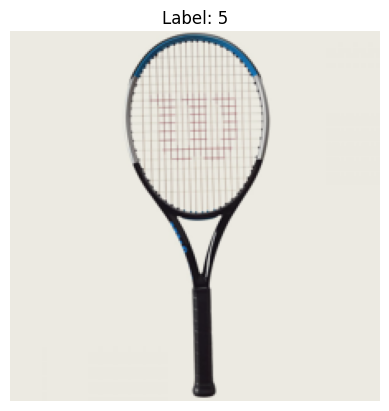

In [116]:
# 反归一化（假设数据集使用ImageNet均值和标准差）
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = (img * std + mean) * 255  # 转换为0-255的uint8格式
img = img.astype(np.uint8)

import matplotlib.pyplot as plt
# 显示图片并标注标签
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

尝试一张图片和text

In [117]:
# 获取一个批次的数据（假设batch_size=32）
images, labels = next(iter(test_loader))
# 选择第一张图片（索引0）进行可视化
img = images[1]  # 调整维度为HWC
label = labels[1].item()
model.eval()
with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    print(img.shape)

    logits_per_image, logits_per_text = model(img, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    print(probs)

torch.Size([1, 3, 224, 224])
[[1.222e-05 2.211e-05 9.995e-01 1.132e-05 2.341e-04 1.621e-05]]


In [118]:
model.eval()
with torch.no_grad():
    image = img.to(device)

    # 计算图像特征|
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    # 计算文本特征
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    # 计算相似度（例如：进行零样本分类）
    similarity = (image_features @ text_features.T).softmax(dim=-1)
    print(similarity)
            
    predicted_indices = similarity.argmax(dim=-1)
    print(predicted_indices)

tensor([[0.1624, 0.1633, 0.1819, 0.1622, 0.1672, 0.1628]], device='cuda:0',
       dtype=torch.float16)
tensor([2], device='cuda:0')


In [137]:
all_preds, all_labels = zeroshot_classifier(test_loader, text_inputs)

/root/miniconda3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [138]:
classification_report(all_labels, all_preds)

'              precision    recall  f1-score   support\n\n           0       0.54      0.99      0.69       200\n           1       0.50      0.99      0.67       200\n           2       0.49      0.99      0.66       200\n           3       0.49      1.00      0.65       200\n           4       0.49      1.00      0.65       200\n           5       1.00      0.01      0.02      1000\n\n    accuracy                           0.50      2000\n   macro avg       0.58      0.83      0.56      2000\nweighted avg       0.75      0.50      0.34      2000\n'

In [139]:
eval(all_preds, all_labels, target_classes)

label_idx	label	precision	recall	F1-score

0	T-shirt	0.5351	0.9900	0.6947

1	guitar	0.5038	0.9900	0.6678

2	badminton-racket	0.4938	0.9950	0.6600

3	baozi	0.4854	1.0000	0.6536

4	lychee	0.4854	1.0000	0.6536

5	others	1.0000	0.0100	0.0198



## 验证两两分类的效果

In [142]:
target_classes = ["T-shirt", "not T-shirt"]

In [143]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)    

['T-shirt', 'not T-shirt']
{'T-shirt': 0, 'not T-shirt': 1}


In [144]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.cat([clip.tokenize(f"{cls}") for cls in target_classes]).to(device)

In [145]:
len(text_inputs)

2

In [146]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [153]:
all_preds, all_labels = zeroshot_classifier(test_loader, text_inputs)

/root/miniconda3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [154]:
eval(all_preds, all_labels, target_classes)

label_idx	label	precision	recall	F1-score

0	T-shirt	0.2525	0.1250	0.1672

1	not T-shirt	0.9079	0.9589	0.9327



In [150]:
classification_report(all_labels, all_preds)

'              precision    recall  f1-score   support\n\n           0       0.21      0.92      0.34       200\n           1       0.99      0.60      0.75      1800\n\n    accuracy                           0.64      2000\n   macro avg       0.60      0.76      0.54      2000\nweighted avg       0.91      0.64      0.71      2000\n'

In [156]:
target_classes = ["guitar", "not guitar"]

In [157]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)    

['guitar', 'not guitar']
{'guitar': 0, 'not guitar': 1}


In [158]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.cat([clip.tokenize(f"{cls}") for cls in target_classes]).to(device)

In [159]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [160]:
all_preds, all_labels = zeroshot_classifier(test_loader, text_inputs)

/root/miniconda3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [161]:
eval(all_preds, all_labels, target_classes)

label_idx	label	precision	recall	F1-score

0	guitar	0.4588	0.9750	0.6240

1	not guitar	0.9968	0.8722	0.9304



In [162]:
target_classes = ["badminton-racket", "not badminton-racket"]

In [163]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)   

['badminton-racket', 'not badminton-racket']
{'badminton-racket': 0, 'not badminton-racket': 1}


In [164]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.cat([clip.tokenize(f"{cls}") for cls in target_classes]).to(device)

In [165]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [166]:
all_preds, all_labels = zeroshot_classifier(test_loader, text_inputs)

/root/miniconda3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [167]:
eval(all_preds, all_labels, target_classes)

label_idx	label	precision	recall	F1-score

0	badminton-racket	0.4205	0.9650	0.5857

1	not badminton-racket	0.9955	0.8522	0.9183



In [168]:
target_classes = ["baozi", "not baozi"]

In [169]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)   

['baozi', 'not baozi']
{'baozi': 0, 'not baozi': 1}


In [170]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.cat([clip.tokenize(f"{cls}") for cls in target_classes]).to(device)

In [171]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [172]:
all_preds, all_labels = zeroshot_classifier(test_loader, text_inputs)

/root/miniconda3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [173]:
eval(all_preds, all_labels, target_classes)

label_idx	label	precision	recall	F1-score

0	baozi	0.1418	0.9900	0.2481

1	not baozi	0.9967	0.3344	0.5008



In [174]:
target_classes = ["lychee", "not lychee"]

In [175]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)   

['lychee', 'not lychee']
{'lychee': 0, 'not lychee': 1}


In [176]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.cat([clip.tokenize(f"{cls}") for cls in target_classes]).to(device)

In [177]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [178]:
all_preds, all_labels = zeroshot_classifier(test_loader, text_inputs)

/root/miniconda3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [179]:
eval(all_preds, all_labels, target_classes)

label_idx	label	precision	recall	F1-score

0	lychee	0.1608	0.9850	0.2765

1	not lychee	0.9961	0.4289	0.5996



## 卡阈值

In [214]:
def get_similarity(test_loader, text_inputs, device="cuda"):
    model.eval()
    # 记录正类和负类的阈值
    pos_res = []
    neg_res = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # 计算图像特征
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            # 计算文本特征
            text_features = model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            logit_scale = model.logit_scale.exp()
        
            # 计算相似度（例如：进行零样本分类）
            similarity = logit_scale * torch.nn.functional.cosine_similarity(image_features, text_features)
            pos_mask = (labels == 0)  # 正类掩码（标签为0）
            neg_mask = (labels == 1)  # 负类掩码（标签为1）

            pos_res.extend(similarity.cpu().numpy()[pos_mask])
            neg_res.extend(similarity.cpu().numpy()[neg_mask])
    return pos_res, neg_res
            

In [181]:
target_classes = ["T-shirt", "not T-shirt"]

In [182]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)  

['T-shirt', 'not T-shirt']
{'T-shirt': 0, 'not T-shirt': 1}


In [183]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.tensor(clip.tokenize("T-shirt")).to(device)

/tmp/ipykernel_1366/3606568352.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_inputs = torch.tensor(clip.tokenize("T-shirt")).to(device)


In [184]:
text_inputs.shape

torch.Size([1, 77])

In [185]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [233]:
pos_res, neg_res = get_similarity(test_loader,text_inputs)

/root/miniconda3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [194]:
print(pos_res)

[27.61, 27.7, 27.95, 25.95, 27.64, 26.98, 28.05, 28.48, 26.66, 27.38, 26.48, 25.64, 28.88, 28.25, 25.14, 26.42, 26.53, 26.95, 26.92, 25.86, 25.73, 28.34, 26.9, 27.25, 26.78, 27.48, 26.47, 25.69, 26.73, 28.16, 25.69, 27.61, 26.73, 26.17, 27.17, 27.94, 26.03, 23.75, 29.39, 27.64, 27.34, 25.61, 29.5, 28.3, 27.56, 27.81, 27.94, 25.19, 28.98, 26.25, 25.75, 24.64, 26.6, 28.08, 28.22, 27.7, 28.72, 28.2, 28.1, 27.25, 27.47, 28.6, 27.86, 26.3, 26.92, 28.3, 27.81, 25.12, 27.69, 28.1, 25.9, 27.7, 26.64, 28.05, 25.73, 25.88, 27.3, 25.78, 27.16, 25.0, 28.16, 29.08, 27.81, 26.44, 26.86, 28.69, 27.48, 28.47, 25.6, 29.72, 28.3, 28.83, 28.56, 26.64, 29.44, 27.16, 27.48, 29.34, 28.3, 28.22, 28.2, 28.05, 27.44, 26.81, 28.73, 26.92, 29.73, 28.69, 28.12, 27.25, 27.66, 28.12, 25.05, 26.14, 23.9, 28.12, 27.0, 27.9, 26.48, 27.22, 29.95, 27.22, 27.98, 26.39, 29.3, 28.6, 27.42, 28.55, 25.61, 27.16, 29.03, 26.42, 29.2, 26.08, 30.69, 25.0, 26.83, 26.92, 27.27, 28.56, 27.69, 26.47, 27.66, 27.34, 28.16, 28.61, 28.1

In [195]:
print(len(pos_res))
print(len(neg_res))

200
1800


In [202]:
def eval_threshold(pos_res, neg_res, threshold):
    pos_res = np.array(pos_res)
    neg_res = np.array(neg_res)
    # 计算tp,fp,fn 这里注意后面的分母是不是会出现nan或者0
    tp = sum(pos_res >= threshold)
    fp = sum(neg_res >= threshold)
    fn = sum(pos_res < threshold)

    # precision = TP / TP + FP
    precision = tp / (tp + fp)

    # recall = TP / TP + FN
    recall = tp / (tp + fn)

    # f1-score = 2 * precision * recall / (precision + recall )
    f1_score = 2 * precision * recall / (precision + recall)

    return f1_score, precision, recall

In [207]:
def find_thresholds(pos_res, neg_res, target_classes):
    thresholds = np.linspace(min(min(pos_res), min(neg_res)), max(max(pos_res), max(neg_res)), 200)

    best_threshold = 0.
    best_f1_score = 0.
    best_precision = 0.
    best_recall = 0.
    f1_scores = []

    for threshold in thresholds:
        f1_score, precision, recall = eval_threshold(pos_res, neg_res, threshold)
        f1_scores.append(f1_score)

        # 判断最佳f1
        if f1_score > best_f1_score:
            # 更新指标
            best_threshold = threshold
            best_f1_score = f1_score
            best_precision = precision
            best_recall = recall

    print(f"{target_classes[0]}_best_threshold", best_threshold)
    print(f"{target_classes[0]}_best_f1_score", best_f1_score)
    print(f"{target_classes[0]}_best_precision", best_precision)
    print(f"{target_classes[0]}_best_recall", best_recall)

    import matplotlib.pyplot as plt
    # print(thresholds)
    # print(f1_scores)
    # 绘制曲线
    plt.figure(figsize=(9, 9))
    plt.plot(thresholds, f1_scores)
    # 绘制最佳点
    plt.scatter(x=best_threshold, y=best_f1_score)
    plt.annotate(f"threshold:{best_threshold:.5f}/f1:{best_f1_score:.5f}", xy=(best_threshold, best_f1_score))
    # 添加文字信息
    plt.xlabel('threshold')
    plt.ylabel('f1_score')
    plt.title(f'{target_classes[0]}_precision:{best_precision:.4f}_recall:{best_recall:.4f}')
    plt.savefig(f'result_{target_classes[0]}_all.jpg')

    print('done')


lychee_best_threshold 27.63269472361809
lychee_best_f1_score 0.9468354430379747
lychee_best_precision 0.958974358974359
lychee_best_recall 0.935
done


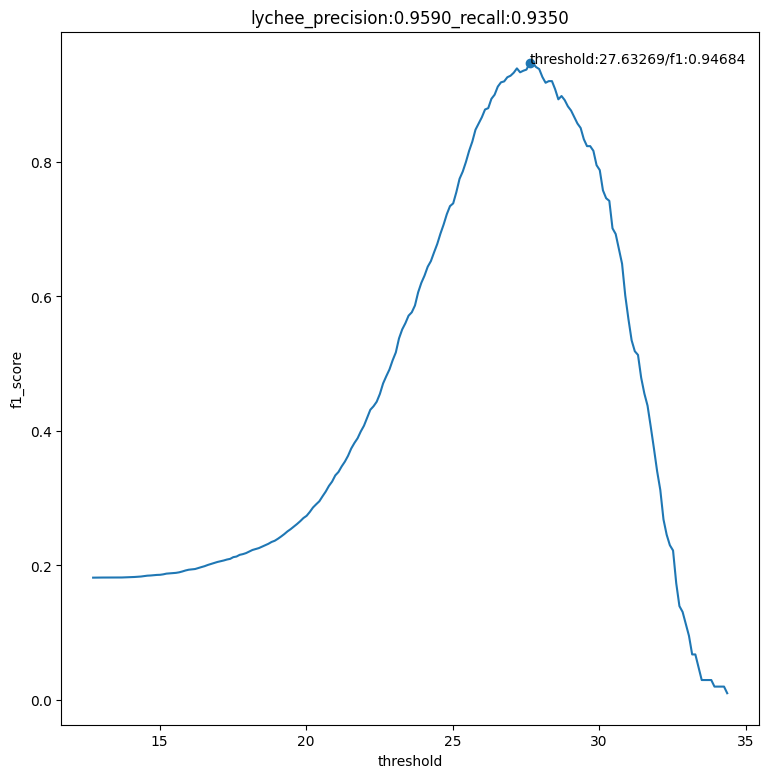

In [234]:
find_thresholds(pos_res, neg_res, target_classes)

更改阈值的方法：
1. 如果准确率低，召回率高，说明阈值设置过于放松，需要将阈值调大；
2. 如果准确率高，召回率低，说明阈值设置过于严苛，需要将阈值调小。

In [209]:
target_classes = ["guitar", "not guitar"]

In [210]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)  

['guitar', 'not guitar']
{'guitar': 0, 'not guitar': 1}


In [211]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.tensor(clip.tokenize("guitar")).to(device)

/tmp/ipykernel_1366/2876371305.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_inputs = torch.tensor(clip.tokenize("guitar")).to(device)


In [212]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [217]:
target_classes = ["badminton-racket", "not badminton-racket"]

In [218]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)  

['badminton-racket', 'not badminton-racket']
{'badminton-racket': 0, 'not badminton-racket': 1}


In [219]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.tensor(clip.tokenize("badminton-racket")).to(device)

/tmp/ipykernel_1366/1489220985.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_inputs = torch.tensor(clip.tokenize("badminton-racket")).to(device)


In [220]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
all_preds, all_labels = zeroshot_classifier_threshold(test_loader, text_inputs, threshold=0.25)

In [223]:
target_classes = ["baozi", "not baozi"]

In [224]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)  

['baozi', 'not baozi']
{'baozi': 0, 'not baozi': 1}


In [225]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.tensor(clip.tokenize("baozi")).to(device)

/tmp/ipykernel_1366/1908063797.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_inputs = torch.tensor(clip.tokenize("baozi")).to(device)


In [226]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
all_preds, all_labels = zeroshot_classifier_threshold(test_loader, text_inputs, threshold=0.27)

In [ ]:
eval(all_labels, all_preds, target_classes)

In [229]:
target_classes = ["lychee", "not lychee"]

In [230]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=preprocess,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)  

['lychee', 'not lychee']
{'lychee': 0, 'not lychee': 1}


In [231]:
# 示例：准备文本输入（将所有类别转换为CLIP的文本特征）
text_inputs = torch.tensor(clip.tokenize("lychee")).to(device)

/tmp/ipykernel_1366/2618461716.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_inputs = torch.tensor(clip.tokenize("lychee")).to(device)


In [232]:
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
all_preds, all_labels = zeroshot_classifier_threshold(test_loader, text_inputs, threshold=0.28)

In [ ]:
eval(all_labels, all_preds, target_classes)